In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.time import Time
#import astropysics.phot as phot
import math
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import sys, time
import numpy as np
import scipy.signal as signal

import scipy
from scipy.stats import linregress
from IPython.display import clear_output

from scipy import stats


def jobs_manager():
    from IPython.lib.backgroundjobs import BackgroundJobManager
    from IPython.core.magic import register_line_magic
    from IPython import get_ipython

    jobs = BackgroundJobManager()

    @register_line_magic
    def job(line):
        ip = get_ipython()
        jobs.new(line, ip.user_global_ns)

    return jobs

jobs = jobs_manager()

In [2]:
def read_file_columns(filename, columns, types=None):
    res = []
    with open(filename, "r") as lines:
        for line in lines:
            if "#" in line:
                continue
            line = line.split()
            l = []
            for i in range(0, len(columns)):
                c = columns[i]
                if types is None:
                    l.append(line[c])
                else:
                    l.append(types[i](line[c]))
            res.append(np.array(l))
    return np.array(res)

In [3]:
coordinates_file = "./coordinates/z0_085_coordinates.dat"
properties_file = "./properties/z0_085.dat"

coord = read_file_columns(coordinates_file, [0, 1, 2, 3], types=[int, int, float, float])
#Subhalo        Group   IsCentral       Mass    Gas     DarkMatter      Stellar Blackhole       BHAccr.Rate     S-F.Rate        Rcirc   Vcirc   Vdisp   X       Y       Z       SDSS.i  SDDD.r  SDDD.g  SDDD.u  SDDD.z
#      0            1           2          3      4              5            6         7                 8            9           10      11    
prop = read_file_columns(properties_file, [0, 5, 6, 7], types=[int, float, float, float])
coord.shape, prop.shape

((4633801, 4), (4633801, 4))

In [4]:
ids = np.intersect1d(coord[:,0], prop[:,0], assume_unique=True)

coord = coord[np.in1d(coord[:,0], ids, assume_unique=True)]
prop = prop[np.in1d(prop[:,0], ids, assume_unique=True)]

In [5]:
all_data=np.concatenate((coord, prop[:,[1,2,3]]), axis=1)
#ID GROUP X Y DarkMatter      Stellar Blackhole
# 0     1 2 3          4            5         6

x = all_data[:,[2, 3, 0]]
subhalos_x = all_data[:,[2, 3, 0]][all_data[:,6] > 0]

In [6]:
x.shape, subhalos_x.shape

((4633801, 3), (68306, 3))

In [7]:
def delta_ellipse(x, y, a2, r2, alpha_sin, alpha_cos):
    s = alpha_sin
    c = alpha_cos
    res = ((x*c + y*s)**2)/a2 + ((-x*s + y*c)**2) <= r2
    return np.count_nonzero(res)

def delta_circle(x, y, r2):
    res = (x**2) + (y**2) <= r2
    return np.count_nonzero(res)

Average: 7989322.146268


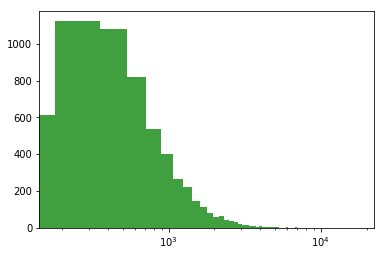

In [8]:
m_x, M_x = np.min(x[:,0]), np.max(x[:,0])
s_x = (M_x - m_x)/100

m_y, M_y = np.min(x[:,1]), np.max(x[:,1])
s_y = (M_y - m_y)/ (100 * (M_y - m_y)/(M_x - m_x))

densities = []
for xi in np.arange(m_x, M_x, s_x):
    y_arr = []
    for yi in np.arange(m_y, M_y, s_y):
        y_arr.append(0)
    densities.append(y_arr)

for l in x:
    l_x = l[0]
    l_y = l[1]
    try:
        densities[int(l_x/s_x)][int(l_y/s_y)]+=1
    except:
        pass

    
dens = []
for i in densities:
    for j in i:
        dens.append(j)
        
average_density = np.average(dens) / (s_x * s_y)
print ("Average: %f" % average_density)
        
plt.hist(dens, 100, facecolor='g', alpha=0.75)
plt.xscale('log')
plt.show()

In [23]:
########### Settings start here ############
a2 = 0.1**2
r2 = 0.02**2
r_void_outer2 = 0.01**2
r_void_inner2 = 0.005**2
N_angles = 24 #must be even, angles in range [0, pi), step pi/N_angles
########### Settings end here ##############

void_threshold = np.pi * r_void_outer2 * average_density
print("Void threshold: %f" % void_threshold)

angles = np.arange(0, N_angles)
angles_sin_cos = [[np.sin(alpha * np.pi/N_angles), np.cos(alpha * np.pi/N_angles)] for alpha in angles]

filaments = []
groups = []
voids = []
done = []

def classify(_subhalos):
    for subhalo in _subhalos:
        f_g = f_v = f_f = False

        x0 = subhalo[0]
        y0 = subhalo[1]
        subhalo_id = subhalo[2]

        dx0 = x[:,0] - x0
        dx1 = x[:,1] - y0

        void_inner = delta_circle(dx0, dx1, r_void_inner2)
        void_outer = delta_circle(dx0, dx1, r_void_outer2)
        if (void_outer - void_inner) / float(void_inner) > 6 and void_inner < void_threshold:
            voids.append(subhalo_id)
        else:
            values = []
            for alpha_s_c in angles_sin_cos:
                d = delta_ellipse(dx0, dx1, a2, r2, alpha_s_c[0], alpha_s_c[1])
                values.append(d)
            values = np.array(values)
            M = np.max(values)
            M_idx = values.argmax()
            M90 = values[(angles == M_idx - len(angles)/2) if M_idx - len(angles)/2 >= 0 else (angles == M_idx + len(angles)/2)][0]    
            if (M/M90 >= 3):
                filaments.append(subhalo_id)
            if (M/M90 <= 2 and M > void_threshold):
                groups.append(subhalo_id)
        done.append(subhalo_id)

Void threshold: 2509.919576


In [24]:
if len(jobs.running) == 0:
    for s in np.array_split(subhalos_x, 16):
        %job classify(s)
else:
    print("Probably something is already running!!!")

Starting job # 17 in a separate thread.
Starting job # 18 in a separate thread.
Starting job # 19 in a separate thread.
Starting job # 20 in a separate thread.
Starting job # 21 in a separate thread.
Starting job # 22 in a separate thread.
Starting job # 23 in a separate thread.
Starting job # 24 in a separate thread.
Starting job # 25 in a separate thread.
Starting job # 26 in a separate thread.
Starting job # 27 in a separate thread.
Starting job # 28 in a separate thread.
Starting job # 29 in a separate thread.
Starting job # 30 in a separate thread.
Starting job # 31 in a separate thread.
Starting job # 32 in a separate thread.


In [45]:
#a = len(done)
#time.sleep(60)
#print (len(done) - a)
print("f %d, g %d, v %d, total %d" % (len(filaments), len(groups), len(voids), len(done))) 
#jobs.status()
#coord[np.in1d(coord[:,0], voids)][:,[0,1]].astype(int)

f 8810, g 8478, v 1098, total 48818


In [42]:
jobs.status()

Running jobs:
17 : classify(s)
18 : classify(s)
19 : classify(s)
20 : classify(s)
21 : classify(s)
22 : classify(s)
23 : classify(s)
24 : classify(s)
25 : classify(s)
26 : classify(s)
27 : classify(s)
28 : classify(s)
29 : classify(s)
30 : classify(s)
31 : classify(s)
32 : classify(s)

Completed jobs:
0 : classify(s)
2 : classify(s)
3 : classify(s)
4 : classify(s)
5 : classify(s)
6 : classify(s)
7 : classify(s)
8 : classify(s)
9 : classify(s)
10 : classify(s)
11 : classify(s)
12 : classify(s)
13 : classify(s)
14 : classify(s)
15 : classify(s)
16 : classify(s)



In [ ]:
stophere

In [ ]:
#filaments = np.array(filaments)
#groups = np.array(groups)
#voids = np.array(voids)

In [46]:
while True:

    print("f %d, g %d, v %d, total %d" % (len(filaments), len(groups), len(voids), len(done))) 

    with open("z0/filaments_ids_t", 'w') as f: 
        for i in filaments:
            f.write("%d\n" % i)

    with open("z0/groups_ids_t", 'w') as f: 
        for i in groups:
            f.write("%d\n" % i)
        
    with open("z0/voids_ids_t", 'w') as f: 
        for i in voids:
            f.write("%d\n" % i)
    time.sleep(600)

f 8811, g 8480, v 1098, total 48823
f 8981, g 8637, v 1116, total 49720
f 9158, g 8752, v 1131, total 50613
f 9324, g 8890, v 1151, total 51515
f 9509, g 9043, v 1165, total 52405
f 9655, g 9194, v 1183, total 53301
f 9811, g 9379, v 1200, total 54199
f 9963, g 9525, v 1220, total 55095
f 10163, g 9683, v 1238, total 55992
f 10341, g 9813, v 1257, total 56889
f 10507, g 10002, v 1281, total 57793
f 10684, g 10152, v 1301, total 58692
f 10855, g 10287, v 1330, total 59602
f 11031, g 10422, v 1358, total 60504
f 11189, g 10588, v 1375, total 61401
f 11359, g 10739, v 1389, total 62292
f 11525, g 10894, v 1412, total 63193
f 11675, g 11019, v 1436, total 64097
f 11822, g 11170, v 1451, total 64989
f 11995, g 11316, v 1474, total 65888
f 12176, g 11456, v 1499, total 66784
f 12376, g 11548, v 1519, total 67689
f 12461, g 11701, v 1524, total 68306
f 12461, g 11701, v 1524, total 68306
f 12461, g 11701, v 1524, total 68306
f 12461, g 11701, v 1524, total 68306
f 12461, g 11701, v 1524, tota

KeyboardInterrupt: 